In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
!pip install --upgrade scipy
#!pip install plotly==5.11.0
# %pip install --upgrade networkx[default]
# %pip install pyinform
# %conda install matplotlib
#%pip install bertopic


Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


In [3]:
# reqruied libraries
import multiprocessing
import pandas as pd
import numpy as np
import datetime
import glob
import os
import re
import time
import datetime
#from scipy import stats
import networkx as nx
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from bumpplot import bumpchart
#from bertopic import BERTopic

In [4]:
from sklearn.preprocessing import MinMaxScaler

In [5]:
from scipy import stats
import seaborn as sns

In [6]:
# s3 specific libraries
import s3fs
import boto3
s3 = s3fs.S3FileSystem(anon=False)

In [7]:
# Running with S3 (inside AWS) ?
RUNNING_IN_S3 = True

In [8]:
# Directories
OUTPUT_DIR = './OUTPUT'

UPLOAD_S3_BUCKET_NAME = 'mips-main'
UPLOAD_S3_BUCKET_SUBFOLDER = 'initial_data_collection/processed_data/actors_and_messages/v4'

#PC_INPUT_DIR = 'C:/STUFF/RESEARCH/Brandwatch/TEST'
PC_INPUT_DIR = 'C:/STUFF/RESEARCH/Brandwatch/DATA/MainQuery/All'
S3_INPUT_DIR = 's3://mips-main/initial_data_collection/raw_data/brandwatch'
INPUT_DIR = S3_INPUT_DIR if RUNNING_IN_S3 else PC_INPUT_DIR

S3_NEWS_DOMAINS_CSV_FILE = 's3://mips-main/initial_data_collection/news_outlets_v3.csv'
PC_NEWS_DOMAINS_CSV_FILE = 'C:/STUFF/RESEARCH/Brandwatch/DATA/news_outlets_v3.csv'
NEWS_DOMAINS_CSV_FILE = S3_NEWS_DOMAINS_CSV_FILE if RUNNING_IN_S3 else PC_NEWS_DOMAINS_CSV_FILE

S3_NEWS_DOMAIN_TUFM_FILE = 's3://mips-main/initial_data_collection/processed_data/news_sources/news_table-v2-UT60-FM5.csv'
PC_NEWS_DOMAIN_TUFM_FILE = 'C:/STUFF/RESEARCH/Brandwatch/DATA/news_table-v2-UT60-FM5.csv'
NEWS_DOMAIN_TUFM_FILE = S3_NEWS_DOMAIN_TUFM_FILE if RUNNING_IN_S3 else PC_NEWS_DOMAIN_TUFM_FILE

In [9]:
# Parameters
SAMPLE_FREQUENCY = 'D'

WINDOW_SHIFT_BY_DAYS = 1
INIT_WINDOW_SIZE = datetime.timedelta(days=4)
IS_GROWING_WINDOW = True # True if Growing, False if Moving

START_DATE = datetime.datetime(2018,3,1)
END_DATE = datetime.datetime(2018,5,1)

MIN_COMM_SIZE = 500
MIN_PLAT_SIZE = 50

KNOWN_PLATFORMS = {'twitter.com', 'tumblr.com', 'youtube.com', 'reddit.com', '4chan.org', 'facebook.com', 'gab.com'}

In [10]:
def read_csv_data(data_directory, filter_platform_domain_set, is_using_s3):
    """
    Reads data from all the csv files in the given directory
    :param data_directory: Path to the directory that contains the csv files
    :type data_directory: str
    :return: pandas Dataframe that contains all the data from all csv files
    :rtype: pd.Dataframe
    """
    data_files = []
    if is_using_s3:
        data_files = s3.glob(os.path.join(data_directory, "*.csv*"))
    else:
        data_files = glob.glob(os.path.join(data_directory, "*.csv*"))
    prefix_path = ''
    if is_using_s3:
        prefix_path = 's3://'
    print(data_files)
    df_list = []
    for idx, file in enumerate(data_files):
        print(f"Reading {idx + 1} of {len(data_files)} files.\nFile name: {file}")
        df = pd.read_csv(prefix_path + data_files[idx], skiprows=6, parse_dates=['Date'],
                         dtype={'Twitter Author ID': str, 'Author':str,
                                'Full Text':str, 'Title':str,
                                'Thread Id':str, 'Thread Author':str,
                                'Mentioned Authors':str,
                                'Domain':str, 'Expanded URLs':str,
                                'Avatar':str, 'Parent Blog Name':str, 'Root Blog Name':str})
        # df = df[['Date', 'Hashtags', 'Twitter Author ID', 'Author', 'Url', 'Thread Id', 'Thread Author', 'Domain']]
        df = df.rename(columns={'Date':'datetime', 'Author': 'source_user_id',
                                'Full Text':'content', 'Title':'title',
                                'Thread Id': 'parent_source_msg_id', 'Thread Author': 'parent_source_user_id',
                                'Mentioned Authors':'mentioned_source_user_id_list_str',
                                'Domain':'platform', 'Expanded URLs':'article_url'})
        df_list.append(df)
        #break #<<---------------------------------------------- REMOVE THIS
        
    start_time = time.time() 
    result_df = pd.concat(df_list)
    end_time = time.time() 
    print(f"{(end_time - start_time)/60} mins for concat dataframes")
    
    result_df['source_user_id'] = result_df['source_user_id'].apply(lambda x: x.lower() if type(x) is str else x)
    result_df['parent_source_user_id'] = result_df['parent_source_user_id'].apply(lambda x: x.lower() if type(x) is str else x)
    
    start_time = time.time() 
    result_df.drop_duplicates(subset='Url', keep="first", inplace=True)
    #result_df.drop_duplicates(keep="first", inplace=True)
    end_time = time.time() 
    print(f"{(end_time - start_time)/60} mins for drop duplicates")
    
    start_time = time.time()
    #result_df['platform'].value_counts().rename('posts_count').rename_axis('platform').to_csv(OUTPUT_DIR + "/platform_counts_info.csv")
    #result_df = result_df[result_df['platform'].isin(filter_platform_domain_set)]
    end_time = time.time() 
    print(f"{(end_time - start_time)/60} mins for filtering platforms")
    
    start_time = time.time()
    result_df['mentioned_source_user_id_list'] = result_df['mentioned_source_user_id_list_str'].apply(lambda x: [e[1:].lower() for e in x.split(', ')] if type(x) is str else [])
    end_time = time.time() 
    print(f"{(end_time - start_time)/60} mins for making lists of mentioned authors column : mentioned_source_user_id_list")
    
    result_df.reset_index(drop=True, inplace=True)
    print(result_df.shape)
    return result_df

In [11]:
%%time
# read data and filter for only the KNOWN_PLATFORMS
all_osn_msgs_df = read_csv_data(INPUT_DIR, KNOWN_PLATFORMS, RUNNING_IN_S3)
all_osn_msgs_df

['mips-main/initial_data_collection/raw_data/brandwatch/2018_03_01_to_2018_03_06_withFb_2033735572_MainQuery.csv.zip', 'mips-main/initial_data_collection/raw_data/brandwatch/2018_03_07_to_2018_03_07_withoutFb_2033735852_MIPs+test.csv.zip', 'mips-main/initial_data_collection/raw_data/brandwatch/2018_03_07_to_2020_05_02_2033753991_MainQuery_FbIgOnly.csv.zip', 'mips-main/initial_data_collection/raw_data/brandwatch/2018_03_07_to_2020_05_02_onlyFb_2033753991_MainQuery_FbIgOnly.csv.zip', 'mips-main/initial_data_collection/raw_data/brandwatch/2018_03_08_to_2018_03_09_withoutFb_2033750044_MIPs+test.csv.zip', 'mips-main/initial_data_collection/raw_data/brandwatch/2018_03_10_to_2018_03_12_withFb_2033755725_MainQuery.csv.zip', 'mips-main/initial_data_collection/raw_data/brandwatch/2018_03_13_to_2018_03_13_withoutFb_2033770110_MainQuery_withoutFb.csv.zip', 'mips-main/initial_data_collection/raw_data/brandwatch/2018_03_14_to_2018_03_14_withoutFb_2033776708_MainQuery_withoutFb.csv.zip', 'mips-main/i

/tmp/ipykernel_7411/2440928883.py:21: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(prefix_path + data_files[idx], skiprows=6, parse_dates=['Date'],


Reading 7 of 22 files.
File name: mips-main/initial_data_collection/raw_data/brandwatch/2018_03_13_to_2018_03_13_withoutFb_2033770110_MainQuery_withoutFb.csv.zip
Reading 8 of 22 files.
File name: mips-main/initial_data_collection/raw_data/brandwatch/2018_03_14_to_2018_03_14_withoutFb_2033776708_MainQuery_withoutFb.csv.zip
Reading 9 of 22 files.
File name: mips-main/initial_data_collection/raw_data/brandwatch/2018_03_15_to_2018_03_15_wihtoutFb_2033770779_MIPs+test.csv.zip
Reading 10 of 22 files.
File name: mips-main/initial_data_collection/raw_data/brandwatch/2018_03_16_to_2018_03_16_withoutFb_2033798850_MIPs+test.csv.zip
Reading 11 of 22 files.
File name: mips-main/initial_data_collection/raw_data/brandwatch/2018_03_17_to_2018_03_19_2033804694_MainQuery_withoutFb.csv.zip
Reading 12 of 22 files.
File name: mips-main/initial_data_collection/raw_data/brandwatch/2018_03_20_to_2018_03_25_2033831837_MainQuery_withoutFb.csv.zip
Reading 13 of 22 files.
File name: mips-main/initial_data_collect

/tmp/ipykernel_7411/2440928883.py:21: DtypeWarning: Columns (62,77,110) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(prefix_path + data_files[idx], skiprows=6, parse_dates=['Date'],


Reading 19 of 22 files.
File name: mips-main/initial_data_collection/raw_data/brandwatch/2018_04_09_to_2018_04_11_withoutFb_2033968986_MIPs+test.csv.zip
Reading 20 of 22 files.
File name: mips-main/initial_data_collection/raw_data/brandwatch/2018_04_12_to_2018_04_15_withoutFb_2033988828_MainQuery_withoutFb.csv.zip
Reading 21 of 22 files.
File name: mips-main/initial_data_collection/raw_data/brandwatch/2018_04_16_to_2018_04_20_withoutFb_2034001178_MainQuery_withoutFb.csv.zip
Reading 22 of 22 files.
File name: mips-main/initial_data_collection/raw_data/brandwatch/2018_04_21_to_2018_05_01_withoutFb_2034010661_MIPs+test.csv.zip
0.02817010482152303 mins for concat dataframes
0.044224301973978676 mins for drop duplicates
3.973642985026042e-09 mins for filtering platforms
0.02044844627380371 mins for making lists of mentioned authors column : mentioned_source_user_id_list
(1114424, 114)
CPU times: user 36.3 s, sys: 3.44 s, total: 39.7 s
Wall time: 53.5 s


,Query Id,Query Name,datetime,title,Url,platform,Sentiment,Page Type,Language,Country Code,...,Reddit Score,Reddit Score Upvote Ratio,Region,Region Code,Root Blog Name,Root Post Id,Subreddit,Subreddit Subscribers,Weblog Title,mentioned_source_user_id_list
0,2001100576,MainQuery,2018-03-06 23:59:57,RT @MarkUrban01 Sources: the poison used on Se...,http://twitter.com/melkaylan/statuses/97117357...,twitter.com,neutral,twitter,en,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,melkaylan (melik kaylan),[]
1,2001100576,MainQuery,2018-03-06 23:59:50,RT @jimsciutto Keep watching this story: forme...,http://twitter.com/prutter_pat/statuses/971173...,twitter.com,neutral,twitter,en,CAN,...,NaN,NaN,Ontario,CAN.ON,NaN,NaN,NaN,NaN,prutter_pat (Pat Rutter),[]
2,2001100576,MainQuery,2018-03-06 23:59:49,RT @BBCTomSymonds Sergei Skripal’s 43 year old...,http://twitter.com/optouttwice/statuses/971173...,twitter.com,negative,twitter,en,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,optouttwice (OptOutTwice 🤔),[]
3,2001100576,MainQuery,2018-03-06 23:59:40,"RT @W7VOA Sergei Skripal, who is 66, was grant...",http://twitter.com/lindhays/statuses/971173499...,twitter.com,neutral,twitter,en,USA,...,NaN,NaN,Montana,USA.MT,NaN,NaN,NaN,NaN,lindhays (Democratic Socialism),[w7voa]
4,2001100576,MainQuery,2018-03-06 23:59:34,RT @KremlinTrolls **Relatives in Russia unable...,http://twitter.com/VedehiMajumdar/statuses/971...,twitter.com,neutral,twitter,en,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,VedehiMajumdar (Vedehi Majumdar),[kremlintrolls]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1114419,2001099695,MIPs test,2018-04-21 00:00:00,NaN,https://hotcopper.com.au/threads/uk-gas-trail-...,hotcopper.com.au,negative,forum,en,AUS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ophir,[]
1114420,2001099695,MIPs test,2018-04-21 00:00:00,"The Qanon posts, and a “Very Bad Day” Scenario...",http://projectavalon.net/forum4/showthread.php...,projectavalon.net,negative,forum,en,USA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cidersomerset,[]
1114421,2001099695,MIPs test,2018-04-21 00:00:00,"Russia Exposes British Lies On Skripal, But Tr...",http://revolutionradio.org/2018/04/21/russia-e...,revolutionradio.org,neutral,blog,en,USA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Russia Exposes British Lies On Skripal, But Tr...",[]
1114422,2001099695,MIPs test,2018-04-21 00:00:00,Syria air strikes: US and allies attack [alleg...,http://projectavalon.net/forum4/showthread.php...,projectavalon.net,negative,forum,en,USA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cidersomerset,[]


In [12]:
%%time
# add user_id column and parent_user_id column

def generate_users_dict(osn_msgs_df):
    global next_user_id
    users_data = {}
    next_user_id = 0
    def extract_user(row):
        global next_user_id
        if (row['platform'], row['source_user_id']) not in users_data:
            users_data[(row['platform'], row['source_user_id'])] = next_user_id
            next_user_id += 1
        if (row['platform'], row['parent_source_user_id']) not in users_data:
            users_data[(row['platform'], row['parent_source_user_id'])] = next_user_id
            next_user_id += 1
    all_osn_msgs_df.apply(lambda row: extract_user(row), axis=1)
    print(len(users_data))
    return users_data

users_data = generate_users_dict(all_osn_msgs_df)

users_df = pd.Series(users_data).rename_axis(['platform','source_user_id']).rename('user_id').reset_index()
print(users_df.shape)
#print(users_df)
#users_df.to_csv(OUTPUT_DIR + "/users.csv",index=False)

# add user_id column and parent_user_id column
all_osn_msgs_df[['user_id','parent_user_id']] = all_osn_msgs_df.apply(lambda row: pd.Series([
            users_data[(row['platform'],row['source_user_id'])],
            users_data[(row['platform'],row['parent_source_user_id'])]
        ]), axis = 1)

248856
(248856, 3)
CPU times: user 2min 37s, sys: 5.27 s, total: 2min 42s
Wall time: 2min 42s


In [13]:
def find_patterns_for_domains(in_news_domains_csv_file, in_add_splits=False, in_skip_strings=None):
    news_domains = pd.read_csv(in_news_domains_csv_file)['news outlets'].rename('news_outlets')
    news_domains_set = set(news_domains.to_list())
    pattern_to_news_domain_name = {re.compile(nd.replace('.','\.')):nd for nd in news_domains_set}
    if in_add_splits:
        for nd in news_domains_set:
            valid_split_strs = set(nd.split('.'))
            for e in in_skip_strings:
                valid_split_strs.discard(e)
            for sp in valid_split_strs:
                if len(sp) > 2:
                    pattern_to_news_domain_name[re.compile(sp)] = nd
    return pattern_to_news_domain_name

def search_domain_in_string(in_expanded_url, in_news_domains_names):
    # print(in_expanded_url)
    max_len_match = None
    max_len_found = 0
    for ndn in in_news_domains_names:
        match_obj = ndn.search(in_expanded_url)
        if match_obj:
            # print(match_obj, in_news_domains_names[ndn], match_obj.end() - match_obj.start())
            if max_len_found < match_obj.end() - match_obj.start():
                max_len_match = ndn
                max_len_found = match_obj.end() - match_obj.start()
    return in_news_domains_names[max_len_match] if max_len_match is not None else None


def calculate_news_domain_series(in_string_series, in_add_splits=False, in_skip_strings=None):
    news_domains_names = find_patterns_for_domains(NEWS_DOMAINS_CSV_FILE, in_add_splits, in_skip_strings)
    return in_string_series.apply(lambda x: search_domain_in_string(x, news_domains_names) if type(x) is str else None)


In [14]:
%%time
# Add news_domains column
all_osn_msgs_df['news_domain'] = calculate_news_domain_series(all_osn_msgs_df['article_url'])

#skip_strings = {'add', 'al', 'au', 'ca', 'com', 'es', 'in', 'is', 'it', 'ms', 'my', 'net', 'news', 'org', 'rs', 'st', 'tv', 'uk', 'us', 'co'}
#all_osn_msgs_df['news_domain_subs'] = calculate_news_domain_series(all_osn_msgs_df['article_url'], True, skip_strings)

# filter only the ones with requested domain names
all_osn_msgs_df = all_osn_msgs_df.loc[all_osn_msgs_df['news_domain'].notnull(), :]

print(f"Num of news domains found in data : {all_osn_msgs_df['news_domain'].nunique()}")

Num of news domains found in data : 268
CPU times: user 2min 21s, sys: 752 ms, total: 2min 22s
Wall time: 2min 22s


In [15]:
all_osn_msgs_df['platform'].unique()

array(['twitter.com'], dtype=object)

In [16]:
all_osn_msgs_df

,Query Id,Query Name,datetime,title,Url,platform,Sentiment,Page Type,Language,Country Code,...,Region Code,Root Blog Name,Root Post Id,Subreddit,Subreddit Subscribers,Weblog Title,mentioned_source_user_id_list,user_id,parent_user_id,news_domain
5,2001100576,MainQuery,2018-03-06 23:59:28,RT @Billbrowder Very disturbing additional fac...,http://twitter.com/Tesscatbird/statuses/971173...,twitter.com,negative,twitter,en,USA,...,USA.CA,NaN,NaN,NaN,NaN,Tesscatbird (Tess),[],10,11,theguardian.com
7,2001100576,MainQuery,2018-03-06 23:59:01,RT @Billbrowder Very disturbing additional fac...,http://twitter.com/crlulukat/statuses/97117333...,twitter.com,negative,twitter,en,NaN,...,NaN,NaN,NaN,NaN,NaN,crlulukat (Kathy 🌼),[],12,11,theguardian.com
9,2001100576,MainQuery,2018-03-06 23:58:36,"RT @NBCNews ""The man went stiff. His arms stop...",http://twitter.com/tiffanyclay/statuses/971173...,twitter.com,negative,twitter,en,NaN,...,NaN,NaN,NaN,NaN,NaN,tiffanyclay (❄️Evidence-Based Tiffany❄️),[],14,15,nbcnews.com
12,2001100576,MainQuery,2018-03-06 23:58:22,RT @Billbrowder Very disturbing additional fac...,http://twitter.com/KarCranky/statuses/97117317...,twitter.com,negative,twitter,en,USA,...,NaN,NaN,NaN,NaN,NaN,KarCranky (KarLen),[],19,11,theguardian.com
14,2001100576,MainQuery,2018-03-06 23:58:22,RT @andreariscassi Counter-terrorism police ta...,http://twitter.com/electricboyo/statuses/97117...,twitter.com,neutral,twitter,en,USA,...,NaN,NaN,NaN,NaN,NaN,electricboyo (Gregory Danner),[andreariscassi],22,23,theguardian.com
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1114403,2001099695,MIPs test,2018-04-21 00:08:04,"Suspects in Attack on Ex-Spy Are in Russia, U....",http://twitter.com/lawsonjessie301/statuses/98...,twitter.com,neutral,twitter,en,NaN,...,NaN,NaN,NaN,NaN,NaN,lawsonjessie301 (ST Media Inc),[],35406,30,nytimes.com
1114404,2001099695,MIPs test,2018-04-21 00:08:04,"Suspects in Attack on Ex-Spy Are in Russia, U....",http://twitter.com/NYT/statuses/98748306769361...,twitter.com,neutral,twitter,en,USA,...,USA.NY,NaN,NaN,NaN,NaN,NYT (NYT),[],380,30,nytimes.com
1114405,2001099695,MIPs test,2018-04-21 00:08:03,"Suspects in Attack on Ex-Spy Are in Russia, U....",http://twitter.com/ElizabethFieshe/statuses/98...,twitter.com,neutral,twitter,en,USA,...,NaN,NaN,NaN,NaN,NaN,ElizabethFieshe (Pine Island Info Inc),[],35379,30,nytimes.com
1114412,2001099695,MIPs test,2018-04-21 00:02:57,"Suspects in Attack on Ex-Spy Are in Russia, U....",http://twitter.com/danilina5886/statuses/98748...,twitter.com,neutral,twitter,en,NaN,...,NaN,NaN,NaN,NaN,NaN,danilina5886 (danilina),[],35313,30,nytimes.com


## Measurements

In [69]:
""" Function for calculating network based measurements """
def calc_network_measurements(in_prefix, in_edge_list_df, in_source_col, in_target_col, in_weight_cols_list=None, in_distance_cols_list=None, in_max_k=200, in_weighted_measurements=False, in_calcfor_weights=False, in_calcfor_distances=False):
    measurements = {}
    
    G_all = nx.from_pandas_edgelist(in_edge_list_df, in_source_col, in_target_col, edge_attr=in_weight_cols_list + in_distance_cols_list, create_using=nx.DiGraph())
    minKNodes = min(G_all.number_of_nodes(), in_max_k)
    
    # Betweenness Centrality
    measurement_name = f'{in_prefix}_BetweennessCent'
    betwCent = nx.betweenness_centrality(G_all, k=minKNodes, weight=(in_distance_cols_list[0] if (in_weighted_measurements and type(in_distance_cols_list) is list) else None))
    betwCent = pd.Series(betwCent).rename(measurement_name).rename_axis('Source')
    measurements[measurement_name] = betwCent
    
    # Eigenvector centrality
    measurement_name = f'{in_prefix}_EigenvectorCent'
    try:
        eigenCent = nx.eigenvector_centrality(G_all.reverse(), max_iter=500, weight=in_weight_cols_list[0] if (in_weighted_measurements and type(in_weight_cols_list) is list) else None)
    except nx.PowerIterationFailedConvergence:
        eigenCent = nx.eigenvector_centrality_numpy(G_all.reverse(), max_iter=500)
    eigenCent = pd.Series(eigenCent).rename(measurement_name).rename_axis('Source')
    measurements[measurement_name] = eigenCent
    
    # Closeness centrality
    measurement_name = f'{in_prefix}_ClosenessCent'
    closeCent = nx.closeness_centrality(G_all.reverse(), distance=in_distance_cols_list[0] if (in_weighted_measurements and type(in_distance_cols_list) is list) else None)
    closeCent = pd.Series(closeCent).rename(measurement_name).rename_axis('Source')
    measurements[measurement_name] = closeCent
    
    # Outdegree in TE network
    measurement_name = f'{in_prefix}_OutDegreeCent'
    tenet_outdegree = nx.out_degree_centrality(G_all)
    tenet_outdegree = pd.Series(tenet_outdegree).rename(measurement_name).rename_axis('Source')
    #tenet_outdegree = in_edge_list_df.groupby(in_source_col).count()[in_target_col].rename(measurement_name).rename_axis('Source')
    measurements[measurement_name] = tenet_outdegree
    
    # Total Outgoing Weights
    list_of_col_vals = (in_weight_cols_list if (in_calcfor_weights and type(in_weight_cols_list) is list) else []) + (in_distance_cols_list if (in_calcfor_distances and type(in_distance_cols_list) is list) else [])
    for col_val in list_of_col_vals:
        measurement_name = f'{in_prefix}_TotalOut{col_val}'
        totaloutte = in_edge_list_df[[in_source_col,in_target_col,col_val]].groupby(in_source_col).sum(col_val).rename(columns={col_val:measurement_name}).rename_axis('Source')
        measurements[measurement_name] = totaloutte
    
    return measurements

### Classical measurements

In [70]:
""" Function for calculating classical measurements based on raw OSN messages data"""
def classical_measurements(in_osn_msgs_df):
    measurements = {}
    
    # Received retweets
    received_retweets = in_osn_msgs_df['parent_source_user_id'].value_counts().rename_axis('Source').rename('ReceivedRetweets')
    measurements['ReceivedRetweets'] = received_retweets
    
    # Number of posts
    numposts = in_osn_msgs_df['source_user_id'].value_counts().rename_axis('Source').rename('NumPosts')
    measurements['NumPosts'] = numposts
    
    # Received mentions
    nummentions = {}
    def markCountedMention(e):
        if e in nummentions:
            nummentions[e] += 1
        else:
            nummentions[e] = 1
    in_osn_msgs_df['mentioned_source_user_id_list'].apply(lambda x: [markCountedMention(e) for e in x if e != ''] )
    nummentions = pd.Series(nummentions).sort_values(ascending=False).rename('ReceivedMentions').rename_axis('Source')
    measurements['ReceivedMentions'] = nummentions
    
    # Received retweets or mentions
    numRTorMent = {}
    def markCountedRetOrMen(e):
        if e in numRTorMent:
            numRTorMent[e] += 1
        else:
            numRTorMent[e] = 1
    def markRetOrMent(x):
        if not x['parent_source_user_id'] is np.nan and x['parent_source_user_id'] != '':
            markCountedRetOrMen(x['parent_source_user_id'])
        for e in x['mentioned_source_user_id_list']:
            if e != x['parent_source_user_id'] and e != '':
                markCountedRetOrMen(e)
    in_osn_msgs_df[['parent_source_user_id','mentioned_source_user_id_list']].apply(lambda x: markRetOrMent(x), axis=1)
    numRTorMent = pd.Series(numRTorMent).sort_values(ascending=False).rename('ReceivedRetweetsOrMentions').rename_axis('Source')
    measurements['ReceivedRetweetsOrMentions'] = numRTorMent
    
    # Received retweets + mentions
    numretmen = pd.merge(received_retweets, nummentions, right_index = True, left_index = True)
    numretmen = numretmen['ReceivedRetweets'] + numretmen['ReceivedMentions']
    numretmen.rename('ReceivedRTs+Mentions', inplace=True)
    measurements['ReceivedRTs+Mentions'] = numretmen
    
    return measurements

In [71]:
%%time
all_measurements = classical_measurements( all_osn_msgs_df[(all_osn_msgs_df['datetime'] > datetime.datetime(2018,3,1)) & (all_osn_msgs_df['datetime'] <= datetime.datetime(2018,5,1))] )
all_measurements

CPU times: user 5.45 s, sys: 336 ms, total: 5.78 s
Wall time: 5.78 s


{'ReceivedRetweets': Source
 rt_com            26922
 craigmurrayorg    15284
 rtuknews           9209
 billbrowder        7747
 20committee        7058
                   ...  
 andrea_tarta          1
 domesticanimal        1
 sabry47314120         1
 presscoreca           1
 comradeyoza           1
 Name: ReceivedRetweets, Length: 9125, dtype: int64,
 'NumPosts': Source
 ferozwala         676
 rogue_corq        553
 rt_com            501
 rlsrussiannews    497
 mlnangalama       457
                  ... 
 biznesalert         1
 jeremyklodsky       1
 80jtl               1
 jay29ers            1
 dronestories        1
 Name: NumPosts, Length: 109468, dtype: int64,
 'ReceivedMentions': Source
 rt_com         15979
 20committee     7880
 independent     5524
 guardian        5042
 rtuknews        4526
                ...  
 djtinthemix        1
 zevshalev          1
 skepticsa          1
 dceiver            1
 bbcukrpg           1
 Name: ReceivedMentions, Length: 8104, dtype: int64,
 

## Retweet Network data

In [80]:
%%time
dfrtedges = all_osn_msgs_df[all_osn_msgs_df['parent_source_user_id'].notnull()][['parent_source_user_id','source_user_id']].value_counts().rename('Weight').reset_index()
dfrtedges['Distance'] = 1000.0 / dfrtedges['Weight']
dfrtedges

CPU times: user 481 ms, sys: 13 µs, total: 481 ms
Wall time: 480 ms


,parent_source_user_id,source_user_id,Weight,Distance
0,rt_com,phildecarolis,255,3.921569
1,rt_com,princessbibirf_,193,5.181347
2,rt_com,news365247live,186,5.376344
3,sjsrana,sjsrana,138,7.246377
4,rt_com,djsiri,125,8.000000
...,...,...,...,...
200969,gordoncorera,andre3verzaal,1,1000.000000
200970,gordoncorera,andreisoldatov,1,1000.000000
200971,gordoncorera,andrw100,1,1000.000000
200972,gordoncorera,andymoz78,1,1000.000000


In [81]:
%%time
RN_measurements = calc_network_measurements('RT', dfrtedges, 'parent_source_user_id', 'source_user_id', ['Weight'], ['Distance'])
RN_measurements

CPU times: user 1min 30s, sys: 82.2 ms, total: 1min 30s
Wall time: 1min 30s


{'RT_BetweennessCent': Source
 rt_com             0.000000e+00
 phildecarolis      0.000000e+00
 princessbibirf_    2.078743e-07
 news365247live     0.000000e+00
 sjsrana            0.000000e+00
                        ...     
 177fe3405b524bc    0.000000e+00
 abersrg            0.000000e+00
 alexanderjohnwg    0.000000e+00
 alphaque           0.000000e+00
 zvezdanews         0.000000e+00
 Name: RT_BetweennessCent, Length: 96215, dtype: float64,
 'RT_EigenvectorCent': Source
 rt_com             2.979063e-01
 phildecarolis      4.389489e-12
 princessbibirf_    4.389489e-11
 news365247live     4.389489e-12
 sjsrana            1.306660e-05
                        ...     
 177fe3405b524bc    4.389489e-12
 abersrg            4.389489e-12
 alexanderjohnwg    4.389489e-12
 alphaque           4.389489e-12
 zvezdanews         4.389489e-11
 Name: RT_EigenvectorCent, Length: 96215, dtype: float64,
 'RT_ClosenessCent': Source
 rt_com             0.096336
 phildecarolis      0.000000
 princessbib

## TE Network data 

In [73]:
actorsdf = pd.read_csv('./OUTPUT/actors.csv', dtype={'actor_id':str,'actor_label':str})
actorsdf['actor_label'] = actorsdf['actor_label'].apply(lambda x: x.lower() if type(x) is str else x)
indv_actor_ids = set(actorsdf[(actorsdf['actor_type'] == 'indv') & (actorsdf['actor_id'] != '1')]['actor_id'])
actor_id_to_label = actorsdf.set_index('actor_id')['actor_label'].to_dict()
actorsdf

,actor_id,actor_label,actor_type,num_users
0,0,twitter.com,plat,415290
1,1,NaN,indv,1
2,2,rt_com,indv,1
3,3,craigmurrayorg,indv,1
4,4,billbrowder,indv,1
...,...,...,...,...
107,107,6,comm,8066
108,108,7,comm,5650
109,109,8,comm,4576
110,110,9,comm,3888


In [74]:
file_name = './OUTPUT/dynamic/growing/actor_te_edges_2018_03_01_2018_05_01.csv'
dfedges = pd.read_csv(file_name, dtype={'Source':str, 'Target':str})
dfedges = dfedges[dfedges['Source'].isin(indv_actor_ids) & dfedges['Target'].isin(indv_actor_ids)]
dfedges['Source'] = dfedges['Source'].apply(lambda x: actor_id_to_label[x])
dfedges['Target'] = dfedges['Target'].apply(lambda x: actor_id_to_label[x])
dfedges

,Source,Target,UF_UF,UF_UM,UF_TF,UF_TM,UM_UF,UM_UM,UM_TF,UM_TM,TF_UF,TF_UM,TF_TF,TF_TM,TM_UF,TM_UM,TM_TF,TM_TM,total_te
224,rt_com,craigmurrayorg,0.00000,0.000000,0.000000,0.000000,0.030480,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.033268,0.000000,0.000000,0.000000,0.063748
225,rt_com,billbrowder,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003879,0.000406,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000809,0.027277,0.032371
226,rt_com,rtuknews,0.00000,0.000000,0.000000,0.000000,0.000000,0.053627,0.000000,0.003879,0.000000,0.000000,0.000000,0.000000,0.000000,0.011726,0.000000,0.000401,0.069633
227,rt_com,neilclark66,0.00000,0.000000,0.000000,0.000000,0.007021,0.037033,0.003879,0.042361,0.000000,0.000000,0.000000,0.000000,0.001660,0.013492,0.087500,0.003388,0.196334
228,rt_com,20committee,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.021316,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001538,0.022854
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11195,peterpobjecky,ninabyzantina,0.00296,0.002960,0.002514,0.004909,0.028946,0.009098,0.009098,0.048556,0.000809,0.000809,0.000401,0.002233,0.016594,0.016594,0.015805,0.003624,0.165911
11196,peterpobjecky,malinka1102,0.02251,0.040558,0.002514,0.006293,0.029745,0.067972,0.009098,0.097258,0.041982,0.023019,0.000401,0.032828,0.063249,0.065417,0.015805,0.038656,0.557305
11197,peterpobjecky,kenroth,0.00000,0.000000,0.000000,0.003063,0.000000,0.000000,0.000000,0.030764,0.000000,0.000000,0.000000,0.006354,0.000000,0.000000,0.000000,0.021053,0.061235
11198,peterpobjecky,benjaminnorton,0.00000,0.000000,0.002960,0.000000,0.000000,0.000000,0.009098,0.000000,0.000000,0.000000,0.000809,0.000000,0.000000,0.000000,0.017410,0.000000,0.030277


In [75]:
def generate_subset_measurements(in_edges_df, in_title, in_measure_column, in_column_renamed, in_source_col='Source', in_target_col='Target', in_threshold=0.1):
    dfedges_filtered_subset = in_edges_df[in_edges_df[in_measure_column] > in_threshold][[in_source_col, in_target_col, in_measure_column]]
    dfedges_filtered_subset.rename(columns={in_measure_column: in_column_renamed}, inplace=True)
    dfedges_filtered_subset[f"1000/{in_column_renamed}"] = 1000.0 / dfedges_filtered_subset[in_column_renamed]
    print(dfedges_filtered_subset.head())
    subset_measurements = calc_network_measurements(in_title, dfedges_filtered_subset, in_source_col, in_target_col, [in_column_renamed], [f"1000/{in_column_renamed}"], in_calcfor_weights=True)
    return subset_measurements

In [76]:
%%time
TEsum_measurements = generate_subset_measurements(dfedges, 'TEsum', 'total_te', 'TEsum')
TEsum_measurements

     Source         Target     TEsum   1000/TEsum
227  rt_com    neilclark66  0.196334  5093.355131
229  rt_com    shoebridgec  0.116269  8600.778929
233  rt_com       ian56789  0.359970  2778.009137
239  rt_com  kremlintrolls  0.163431  6118.803445
244  rt_com         naj562  0.162753  6144.298106
CPU times: user 87.2 ms, sys: 3.97 ms, total: 91.2 ms
Wall time: 90.3 ms


{'TEsum_BetweennessCent': Source
 rt_com            0.002513
 neilclark66       0.017046
 shoebridgec       0.039494
 ian56789          0.054928
 kremlintrolls     0.022204
                     ...   
 mollymckew        0.000008
 olganyc1211       0.000000
 pickardje         0.000414
 julianassange     0.000250
 thatginamiller    0.000000
 Name: TEsum_BetweennessCent, Length: 97, dtype: float64,
 'TEsum_EigenvectorCent': Source
 rt_com            0.137750
 neilclark66       0.157133
 shoebridgec       0.160370
 ian56789          0.196086
 kremlintrolls     0.163298
                     ...   
 mollymckew        0.014363
 olganyc1211       0.012342
 pickardje         0.045264
 julianassange     0.024576
 thatginamiller    0.017388
 Name: TEsum_EigenvectorCent, Length: 97, dtype: float64,
 'TEsum_ClosenessCent': Source
 rt_com            0.582542
 neilclark66       0.617729
 shoebridgec       0.630422
 ian56789          0.708013
 kremlintrolls     0.621903
                     ...   
 mo

In [77]:
%%time
TM_TM_measurements = generate_subset_measurements(dfedges, 'TM_TM', 'TM_TM', '_TM_TM')
TM_TM_measurements

          Source         Target    _TM_TM  1000/_TM_TM
460  billbrowder        nbcnews  0.173286  5770.790496
461  billbrowder  kremlintrolls  0.104853  9537.136852
492  billbrowder           time  0.113362  8821.281683
496  billbrowder          msnbc  0.130911  7638.767394
725  neilclark66        moonofa  0.137916  7250.815488
CPU times: user 28 ms, sys: 0 ns, total: 28 ms
Wall time: 27.1 ms


{'TM_TM_BetweennessCent': Source
 billbrowder      0.000000
 nbcnews          0.026572
 kremlintrolls    0.064997
 time             0.009845
 msnbc            0.026166
                    ...   
 rtuknews         0.000000
 vanessabeeley    0.000000
 pickardje        0.002534
 markurban01      0.000000
 kenroth          0.000000
 Name: TM_TM_BetweennessCent, Length: 85, dtype: float64,
 'TM_TM_EigenvectorCent': Source
 billbrowder      1.579270e-01
 nbcnews          1.034479e-01
 kremlintrolls    2.410742e-01
 time             1.395829e-01
 msnbc            4.188459e-02
                      ...     
 rtuknews         5.949126e-12
 vanessabeeley    5.949126e-12
 pickardje        2.781332e-02
 markurban01      5.949126e-12
 kenroth          2.278691e-01
 Name: TM_TM_EigenvectorCent, Length: 85, dtype: float64,
 'TM_TM_ClosenessCent': Source
 billbrowder      0.218663
 nbcnews          0.223934
 kremlintrolls    0.248684
 time             0.238636
 msnbc            0.195248
              

In [78]:
%%time
UM_TM_measurements = generate_subset_measurements(dfedges, 'UM_TM', 'UM_TM', '_UM_TM')
UM_TM_measurements

       Source           Target    _UM_TM  1000/_UM_TM
233    rt_com         ian56789  0.115474  8659.932786
278    rt_com     guardiannews  0.122887  8137.552756
283    rt_com  businessinsider  0.105968  9436.801678
560  rtuknews      neilclark66  0.107218  9326.823234
564  rtuknews      independent  0.116588  8577.228824
CPU times: user 13 ms, sys: 37 µs, total: 13 ms
Wall time: 12.2 ms


{'UM_TM_BetweennessCent': Source
 rt_com             0.004228
 ian56789           0.010042
 guardiannews       0.000000
 businessinsider    0.000000
 rtuknews           0.004228
 neilclark66        0.008457
 independent        0.000000
 guardian           0.000000
 nytimes            0.000000
 nytimesworld       0.000000
 kylegriffin1       0.000000
 juliadavisnews     0.000000
 shoebridgec        0.000000
 georgegalloway     0.021934
 prisonplanet       0.000000
 socialistvoice     0.000000
 zerohedge          0.000000
 wsj                0.000000
 ilvestoomas        0.000000
 npr                0.000000
 defendingdemo      0.000000
 johnwight1         0.000000
 moonofa            0.000000
 dwilliam9940       0.018235
 grahamwp_uk        0.017706
 peterpobjecky      0.008192
 _irishrepublic     0.011892
 reuters            0.000000
 thetimes           0.000000
 russ_warrior       0.000000
 dailymailuk        0.000000
 vanessabeeley      0.000529
 msnbc              0.000000
 guyverhof

In [79]:
%%time
UF_TM_measurements = generate_subset_measurements(dfedges, 'UF_TM', 'UF_TM', '_UF_TM')
UF_TM_measurements

              Source        Target    _UF_TM  1000/_UF_TM
375   craigmurrayorg        cnnbrk  0.102626  9744.100977
389   craigmurrayorg  guardiannews  0.111563  8963.505255
978      shoebridgec  markgaleotti  0.100206  9979.453589
1401        ian56789     ajenglish  0.144880  6902.268189
1413        ian56789    taraskuzio  0.106971  9348.310327
CPU times: user 24.4 ms, sys: 15 µs, total: 24.4 ms
Wall time: 23.6 ms


{'UF_TM_BetweennessCent': Source
 craigmurrayorg    0.000000
 cnnbrk            0.000000
 guardiannews      0.000000
 shoebridgec       0.000000
 markgaleotti      0.000000
 ian56789          0.000000
 ajenglish         0.000000
 taraskuzio        0.000000
 naj562            0.000000
 neilclark66       0.000000
 russ_warrior      0.001323
 georgegalloway    0.000000
 tahoesquaw1       0.000000
 bbcworld          0.000000
 moscowtimes       0.000000
 defendingdemo     0.000000
 skwawkbox         0.000000
 vanessabeeley     0.000000
 tomlondon6        0.000000
 jelle_simons      0.000000
 city_affairs      0.000000
 wsj               0.000000
 grahamwp_uk       0.001323
 hepworthclare     0.000000
 nbcnews           0.000000
 _irishrepublic    0.000000
 malinka1102       0.000000
 peterpobjecky     0.000000
 johnwight1        0.000000
 Name: UF_TM_BetweennessCent, dtype: float64,
 'UF_TM_EigenvectorCent': Source
 craigmurrayorg    1.450524e-06
 cnnbrk            1.037399e-12
 guardiannew

## Comparison of measurements

In [82]:
%%time
all_measurements.update(TEsum_measurements)
all_measurements.update(TM_TM_measurements)
all_measurements.update(UM_TM_measurements)
all_measurements.update(UF_TM_measurements)
all_measurements.update(RN_measurements)
all_measurements

CPU times: user 18 µs, sys: 0 ns, total: 18 µs
Wall time: 21.9 µs


{'ReceivedRetweets': Source
 rt_com            26922
 craigmurrayorg    15284
 rtuknews           9209
 billbrowder        7747
 20committee        7058
                   ...  
 andrea_tarta          1
 domesticanimal        1
 sabry47314120         1
 presscoreca           1
 comradeyoza           1
 Name: ReceivedRetweets, Length: 9125, dtype: int64,
 'NumPosts': Source
 ferozwala         676
 rogue_corq        553
 rt_com            501
 rlsrussiannews    497
 mlnangalama       457
                  ... 
 biznesalert         1
 jeremyklodsky       1
 80jtl               1
 jay29ers            1
 dronestories        1
 Name: NumPosts, Length: 109468, dtype: int64,
 'ReceivedMentions': Source
 rt_com         15979
 20committee     7880
 independent     5524
 guardian        5042
 rtuknews        4526
                ...  
 djtinthemix        1
 zevshalev          1
 skepticsa          1
 dceiver            1
 bbcukrpg           1
 Name: ReceivedMentions, Length: 8104, dtype: int64,
 

In [83]:
""" Function for combining measurements """
def combine_measurements(in_measurements):
    # combine by merging the measurements
    keys_list = list(in_measurements.keys())
    key = keys_list[0]
    df = pd.DataFrame(in_measurements[key])
    for idx in range(1, len(keys_list)):
        key = keys_list[idx]
        df = df.merge(in_measurements[key], how='outer', on='Source')
    df.fillna(0, inplace=True)
    return df

def add_ranked_columns(inout_df_measurements, in_measurement_cols):
    # add a ranked column for each measurement
    measuremnts_list = list(in_measurement_cols)
    measurment_ranks_list = []
    for msmnt in measuremnts_list:
        msmnt_rank_name = f"{msmnt}_Rank"
        inout_df_measurements[msmnt_rank_name] = inout_df_measurements[msmnt].rank(ascending=False)
        measurment_ranks_list.append(msmnt_rank_name)
    print(f"Returning added ranked colum names: {measurment_ranks_list}")
    return measurment_ranks_list

In [84]:
df_measurements = combine_measurements(all_measurements)
ranked_measurements = add_ranked_columns(df_measurements, all_measurements.keys())
df_measurements

Returning added ranked colum names: ['ReceivedRetweets_Rank', 'NumPosts_Rank', 'ReceivedMentions_Rank', 'ReceivedRetweetsOrMentions_Rank', 'ReceivedRTs+Mentions_Rank', 'TEsum_BetweennessCent_Rank', 'TEsum_EigenvectorCent_Rank', 'TEsum_ClosenessCent_Rank', 'TEsum_OutDegreeCent_Rank', 'TEsum_TotalOutTEsum_Rank', 'TM_TM_BetweennessCent_Rank', 'TM_TM_EigenvectorCent_Rank', 'TM_TM_ClosenessCent_Rank', 'TM_TM_OutDegreeCent_Rank', 'TM_TM_TotalOut_TM_TM_Rank', 'UM_TM_BetweennessCent_Rank', 'UM_TM_EigenvectorCent_Rank', 'UM_TM_ClosenessCent_Rank', 'UM_TM_OutDegreeCent_Rank', 'UM_TM_TotalOut_UM_TM_Rank', 'UF_TM_BetweennessCent_Rank', 'UF_TM_EigenvectorCent_Rank', 'UF_TM_ClosenessCent_Rank', 'UF_TM_OutDegreeCent_Rank', 'UF_TM_TotalOut_UF_TM_Rank', 'RT_BetweennessCent_Rank', 'RT_EigenvectorCent_Rank', 'RT_ClosenessCent_Rank', 'RT_OutDegreeCent_Rank']


,ReceivedRetweets,NumPosts,ReceivedMentions,ReceivedRetweetsOrMentions,ReceivedRTs+Mentions,TEsum_BetweennessCent,TEsum_EigenvectorCent,TEsum_ClosenessCent,TEsum_OutDegreeCent,TEsum_TotalOutTEsum,...,UM_TM_TotalOut_UM_TM_Rank,UF_TM_BetweennessCent_Rank,UF_TM_EigenvectorCent_Rank,UF_TM_ClosenessCent_Rank,UF_TM_OutDegreeCent_Rank,UF_TM_TotalOut_UF_TM_Rank,RT_BetweennessCent_Rank,RT_EigenvectorCent_Rank,RT_ClosenessCent_Rank,RT_OutDegreeCent_Rank
Source,,,,,,,,,,,,,,,,,,,,,
rt_com,26922.0,501.0,15979.0,28142.0,42901.0,0.002513,0.137750,0.582542,0.322917,4.939304,...,11.0,56354.0,56354.5,56359.5,56359.5,56359.5,57215.5,5.0,2.0,1.0
craigmurrayorg,15284.0,22.0,4521.0,19316.0,19805.0,0.000459,0.036394,0.462521,0.093750,1.056938,...,56363.5,56354.0,7.0,5.0,5.0,6.0,57215.5,1.0,29.0,2.0
rtuknews,9209.0,210.0,4526.0,9335.0,13735.0,0.006996,0.134994,0.586253,0.343750,5.796231,...,5.0,56354.0,56354.5,56359.5,56359.5,56359.5,57215.5,2.0,6.0,5.0
billbrowder,7747.0,7.0,110.0,7856.0,7857.0,0.001930,0.081583,0.532033,0.218750,3.130252,...,56363.5,56354.0,56354.5,56359.5,56359.5,56359.5,57215.5,124.0,1.0,3.0
20committee,7058.0,36.0,7880.0,8033.0,14938.0,0.000269,0.056973,0.508517,0.125000,1.634712,...,56363.5,56354.0,56354.5,56359.5,56359.5,56359.5,10.0,231.0,21.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
padraigpostal,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,56363.5,56354.0,56354.5,56359.5,56359.5,56359.5,57215.5,52676.5,60710.5,60921.5
arrghgtr,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,56363.5,56354.0,56354.5,56359.5,56359.5,56359.5,57215.5,52676.5,60710.5,60921.5
absolute_intj,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,56363.5,56354.0,56354.5,56359.5,56359.5,56359.5,57215.5,52676.5,60710.5,60921.5


In [85]:
top_rank_sample_percentage = 0.005
min_rank = top_rank_sample_percentage * df_measurements.shape[0]
min_rank = 100
min_rank

100

In [86]:
actor_of_interest = set()
for rankCol in ranked_measurements:
    actor_of_interest.update( set(df_measurements[df_measurements[rankCol] <= min_rank].index) )
print(len(actor_of_interest))
actor_of_interest

417


{'10downingstreet',
 '20committee',
 '21wire',
 '2ndnewmoon',
 '5150power',
 '55krissi55',
 '_dpaj',
 '_irishrepublic',
 '_jakubjanda',
 '_nomoreexcuses',
 '_thepage',
 'a_rockas',
 'aauk41',
 'abookwormturns',
 'afp',
 'ajenews',
 'ajenglish',
 'alanmcpartlands',
 'ali9l9',
 'alihadi68',
 'amb_yakovenko',
 'andersblinde',
 'andrew__roth',
 'andyweberncb',
 'anniemachon',
 'anon_decoder',
 'anthony18602671',
 'ap',
 'arktinentuuli',
 'asluhn',
 'atamansikka',
 'atlanticcouncil',
 'atvar99',
 'axios',
 'ayeur_ayeur',
 'bbcbreaking',
 'bbcdaniels',
 'bbcdomc',
 'bbcmonitoring',
 'bbcnews',
 'bbcnormans',
 'bbcstever',
 'bbcworld',
 'benimmo',
 'benjaminnorton',
 'benjaminwittes',
 'billbrowder',
 'binomo_rebel',
 'bjarnekim',
 'bluebugaboo2',
 'blysx',
 'bodhibrian',
 'bolshevik1953',
 'borisjohnson',
 "borisjohnson's",
 'bot_political',
 'brian_whit',
 'brought_to_you',
 'bruno_paul',
 'businessinsider',
 'bv',
 'bwiedwards',
 'caitoz',
 'carlaspade',
 'carneross',
 'carolehope2',
 'cbc

In [87]:
df_measurements = df_measurements[df_measurements.index.isin(actor_of_interest)]
df_measurements

,ReceivedRetweets,NumPosts,ReceivedMentions,ReceivedRetweetsOrMentions,ReceivedRTs+Mentions,TEsum_BetweennessCent,TEsum_EigenvectorCent,TEsum_ClosenessCent,TEsum_OutDegreeCent,TEsum_TotalOutTEsum,...,UM_TM_TotalOut_UM_TM_Rank,UF_TM_BetweennessCent_Rank,UF_TM_EigenvectorCent_Rank,UF_TM_ClosenessCent_Rank,UF_TM_OutDegreeCent_Rank,UF_TM_TotalOut_UF_TM_Rank,RT_BetweennessCent_Rank,RT_EigenvectorCent_Rank,RT_ClosenessCent_Rank,RT_OutDegreeCent_Rank
Source,,,,,,,,,,,,,,,,,,,,,
rt_com,26922.0,501.0,15979.0,28142.0,42901.0,0.002513,1.377501e-01,0.582542,0.322917,4.939304,...,11.0,56354.0,56354.5,56359.5,56359.5,56359.5,57215.5,5.0,2.0,1.0
craigmurrayorg,15284.0,22.0,4521.0,19316.0,19805.0,0.000459,3.639360e-02,0.462521,0.093750,1.056938,...,56363.5,56354.0,7.0,5.0,5.0,6.0,57215.5,1.0,29.0,2.0
rtuknews,9209.0,210.0,4526.0,9335.0,13735.0,0.006996,1.349936e-01,0.586253,0.343750,5.796231,...,5.0,56354.0,56354.5,56359.5,56359.5,56359.5,57215.5,2.0,6.0,5.0
billbrowder,7747.0,7.0,110.0,7856.0,7857.0,0.001930,8.158272e-02,0.532033,0.218750,3.130252,...,56363.5,56354.0,56354.5,56359.5,56359.5,56359.5,57215.5,124.0,1.0,3.0
20committee,7058.0,36.0,7880.0,8033.0,14938.0,0.000269,5.697322e-02,0.508517,0.125000,1.634712,...,56363.5,56354.0,56354.5,56359.5,56359.5,56359.5,10.0,231.0,21.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ofcom,0.0,0.0,593.0,593.0,0.0,0.000000,0.000000e+00,0.000000,0.000000,0.000000,...,56363.5,56354.0,56354.5,56359.5,56359.5,56359.5,57215.5,104460.5,60710.5,60921.5
parallelpond,0.0,0.0,518.0,518.0,0.0,0.000000,0.000000e+00,0.000000,0.000000,0.000000,...,56363.5,56354.0,56354.5,56359.5,56359.5,56359.5,57215.5,104460.5,60710.5,60921.5
potus,0.0,0.0,334.0,334.0,0.0,0.000000,0.000000e+00,0.000000,0.000000,0.000000,...,56363.5,56354.0,56354.5,56359.5,56359.5,56359.5,57215.5,104460.5,60710.5,60921.5


In [88]:
def calculate_vs_colYs(colx, coly):
    if colx == coly:
        return [colx, coly, 1.0, 0.0]
    x = df_measurements[colx]
    y = df_measurements[coly]
    def statistic(x):  # permute only `x`
        return stats.spearmanr(x, y).statistic
    if df_measurements.shape[0] > 500:
        res_asymptotic = stats.spearmanr(x, y)
        res = res_asymptotic
        print(f"Asymptotic SRC: {colx} -> {coly} value = {res_asymptotic.statistic}, \t pvalue = {res_asymptotic.pvalue}")
    else:
        res_exact = stats.permutation_test((x,), statistic, permutation_type='pairings')
        res = res_exact
        print(f"Exact SRC     : {colx} -> {coly} value = {res_exact.statistic}, \t pvalue = {res_exact.pvalue}")
    # asymptotic pvalue is too low 
    return [colx, coly, res.statistic, res.pvalue]
    
def calculate_all_SRC():
    with multiprocessing.Pool(multiprocessing.cpu_count() - 1) as pool:
        params = [(colx, coly) for colx in measurementCols for coly in measurementCols]
        results = pool.starmap(calculate_vs_colYs, params)
    return results

In [89]:
%%time
measurementCols = list(all_measurements.keys())
print(f"COLS : {measurementCols}")

srcdf = calculate_all_SRC()
#srcdf

COLS : ['ReceivedRetweets', 'NumPosts', 'ReceivedMentions', 'ReceivedRetweetsOrMentions', 'ReceivedRTs+Mentions', 'TEsum_BetweennessCent', 'TEsum_EigenvectorCent', 'TEsum_ClosenessCent', 'TEsum_OutDegreeCent', 'TEsum_TotalOutTEsum', 'TM_TM_BetweennessCent', 'TM_TM_EigenvectorCent', 'TM_TM_ClosenessCent', 'TM_TM_OutDegreeCent', 'TM_TM_TotalOut_TM_TM', 'UM_TM_BetweennessCent', 'UM_TM_EigenvectorCent', 'UM_TM_ClosenessCent', 'UM_TM_OutDegreeCent', 'UM_TM_TotalOut_UM_TM', 'UF_TM_BetweennessCent', 'UF_TM_EigenvectorCent', 'UF_TM_ClosenessCent', 'UF_TM_OutDegreeCent', 'UF_TM_TotalOut_UF_TM', 'RT_BetweennessCent', 'RT_EigenvectorCent', 'RT_ClosenessCent', 'RT_OutDegreeCent']
Exact SRC     : ReceivedRTs+Mentions -> TM_TM_BetweennessCent value = 0.4691799987024507, 	 pvalue = 0.0002
Exact SRC     : ReceivedRetweets -> RT_OutDegreeCent value = 0.9944695439703037, 	 pvalue = 0.0002
Exact SRC     : TEsum_EigenvectorCent -> UF_TM_ClosenessCent value = 0.3862770051976886, 	 pvalue = 0.0002
Exact SRC

In [92]:
srcdf = pd.DataFrame(srcdf, columns=['x','y', 'SRC', 'pval'])
srcdf

,x,y,SRC,pval
0,ReceivedRetweets,ReceivedRetweets,1.000000,0.0000
1,ReceivedRetweets,NumPosts,-0.102425,0.0408
2,ReceivedRetweets,ReceivedMentions,0.468587,0.0002
3,ReceivedRetweets,ReceivedRetweetsOrMentions,0.816035,0.0002
4,ReceivedRetweets,ReceivedRTs+Mentions,0.775406,0.0002
...,...,...,...,...
836,RT_OutDegreeCent,UF_TM_TotalOut_UF_TM,0.215352,0.0002
837,RT_OutDegreeCent,RT_BetweennessCent,0.054381,0.2772
838,RT_OutDegreeCent,RT_EigenvectorCent,0.537364,0.0002
839,RT_OutDegreeCent,RT_ClosenessCent,0.635384,0.0002


In [93]:
orderedMeasures = measurementCols
#orderedMeasures = measurementCols[:10] + measurementCols[-5:-1]
#orderedMeasures = [measurementCols[0]] + measurementCols[5:-5]

In [94]:
orderedMeasures

['ReceivedRetweets',
 'NumPosts',
 'ReceivedMentions',
 'ReceivedRetweetsOrMentions',
 'ReceivedRTs+Mentions',
 'TEsum_BetweennessCent',
 'TEsum_EigenvectorCent',
 'TEsum_ClosenessCent',
 'TEsum_OutDegreeCent',
 'TEsum_TotalOutTEsum',
 'TM_TM_BetweennessCent',
 'TM_TM_EigenvectorCent',
 'TM_TM_ClosenessCent',
 'TM_TM_OutDegreeCent',
 'TM_TM_TotalOut_TM_TM',
 'UM_TM_BetweennessCent',
 'UM_TM_EigenvectorCent',
 'UM_TM_ClosenessCent',
 'UM_TM_OutDegreeCent',
 'UM_TM_TotalOut_UM_TM',
 'UF_TM_BetweennessCent',
 'UF_TM_EigenvectorCent',
 'UF_TM_ClosenessCent',
 'UF_TM_OutDegreeCent',
 'UF_TM_TotalOut_UF_TM',
 'RT_BetweennessCent',
 'RT_EigenvectorCent',
 'RT_ClosenessCent',
 'RT_OutDegreeCent']

In [95]:
srcpivot = srcdf.pivot(index='x', columns='y', values='SRC')
srcpivot = srcpivot.loc[orderedMeasures,orderedMeasures]
srcpivot

y,ReceivedRetweets,NumPosts,ReceivedMentions,ReceivedRetweetsOrMentions,ReceivedRTs+Mentions,TEsum_BetweennessCent,TEsum_EigenvectorCent,TEsum_ClosenessCent,TEsum_OutDegreeCent,TEsum_TotalOutTEsum,...,UM_TM_TotalOut_UM_TM,UF_TM_BetweennessCent,UF_TM_EigenvectorCent,UF_TM_ClosenessCent,UF_TM_OutDegreeCent,UF_TM_TotalOut_UF_TM,RT_BetweennessCent,RT_EigenvectorCent,RT_ClosenessCent,RT_OutDegreeCent
x,,,,,,,,,,,,,,,,,,,,,
ReceivedRetweets,1.000000,-0.102425,0.468587,0.816035,0.775406,0.618964,0.630154,0.620422,0.621184,0.621616,...,0.313928,0.074855,0.091072,0.224056,0.224056,0.223931,0.059434,0.536317,0.619928,0.994470
NumPosts,-0.102425,1.000000,-0.119616,-0.311781,-0.143638,-0.010387,-0.041730,-0.029521,-0.031077,-0.030971,...,0.129623,0.026113,0.069994,0.093773,0.093786,0.093872,0.287790,-0.147173,-0.297745,-0.133744
ReceivedMentions,0.468587,-0.119616,1.000000,0.724896,0.803421,0.326369,0.315493,0.322789,0.321888,0.321952,...,0.219174,0.005640,-0.016815,0.142906,0.142941,0.142949,0.011363,0.187240,0.227638,0.464889
ReceivedRetweetsOrMentions,0.816035,-0.311781,0.724896,1.000000,0.864806,0.570666,0.580071,0.572102,0.572716,0.573023,...,0.286354,0.059409,0.084900,0.197181,0.197185,0.197008,-0.071620,0.352039,0.428278,0.810221
ReceivedRTs+Mentions,0.775406,-0.143638,0.803421,0.864806,1.000000,0.541286,0.554152,0.547668,0.547410,0.547649,...,0.298487,0.062250,0.058307,0.207194,0.207200,0.207082,-0.021428,0.377940,0.439941,0.772861
TEsum_BetweennessCent,0.618964,-0.010387,0.326369,0.570666,0.541286,1.000000,0.968637,0.976186,0.976776,0.976991,...,0.470195,0.156280,0.082226,0.397122,0.397120,0.397152,0.007765,0.304872,0.350962,0.614317
TEsum_EigenvectorCent,0.630154,-0.041730,0.315493,0.580071,0.554152,0.968637,1.000000,0.992051,0.992081,0.992052,...,0.482043,0.154234,0.075631,0.386277,0.386278,0.386344,-0.017242,0.302586,0.342075,0.626800
TEsum_ClosenessCent,0.620422,-0.029521,0.322789,0.572102,0.547668,0.976186,0.992051,1.000000,0.999819,0.999761,...,0.486617,0.156430,0.077577,0.388836,0.388836,0.388905,-0.010765,0.293011,0.338580,0.616525
TEsum_OutDegreeCent,0.621184,-0.031077,0.321888,0.572716,0.547410,0.976776,0.992081,0.999819,1.000000,0.999911,...,0.486267,0.156431,0.077144,0.389709,0.389709,0.389774,-0.010474,0.293443,0.338380,0.617386


In [96]:
srcpivot2 = srcdf.pivot(index='x', columns='y', values='pval')
srcpivot2 = srcpivot2.loc[orderedMeasures,orderedMeasures]
srcpivot2

y,ReceivedRetweets,NumPosts,ReceivedMentions,ReceivedRetweetsOrMentions,ReceivedRTs+Mentions,TEsum_BetweennessCent,TEsum_EigenvectorCent,TEsum_ClosenessCent,TEsum_OutDegreeCent,TEsum_TotalOutTEsum,...,UM_TM_TotalOut_UM_TM,UF_TM_BetweennessCent,UF_TM_EigenvectorCent,UF_TM_ClosenessCent,UF_TM_OutDegreeCent,UF_TM_TotalOut_UF_TM,RT_BetweennessCent,RT_EigenvectorCent,RT_ClosenessCent,RT_OutDegreeCent
x,,,,,,,,,,,,,,,,,,,,,
ReceivedRetweets,0.0000,0.0408,0.0002,0.0002,0.0002,0.0002,0.0002,0.0002,0.0002,0.0002,...,0.0002,0.1420,0.0590,0.0002,0.0002,0.0002,0.2234,0.0002,0.0002,0.0002
NumPosts,0.0340,0.0000,0.0172,0.0002,0.0040,0.8434,0.3892,0.5228,0.5240,0.5228,...,0.0082,0.5952,0.1568,0.0542,0.0558,0.0618,0.0002,0.0036,0.0002,0.0074
ReceivedMentions,0.0002,0.0136,0.0000,0.0002,0.0002,0.0002,0.0002,0.0002,0.0002,0.0002,...,0.0002,0.9064,0.7402,0.0022,0.0036,0.0026,0.8110,0.0002,0.0002,0.0002
ReceivedRetweetsOrMentions,0.0002,0.0002,0.0002,0.0000,0.0002,0.0002,0.0002,0.0002,0.0002,0.0002,...,0.0002,0.2554,0.0758,0.0002,0.0002,0.0002,0.1488,0.0002,0.0002,0.0002
ReceivedRTs+Mentions,0.0002,0.0034,0.0002,0.0002,0.0000,0.0002,0.0002,0.0002,0.0002,0.0002,...,0.0002,0.2314,0.2428,0.0002,0.0002,0.0002,0.6578,0.0002,0.0002,0.0002
TEsum_BetweennessCent,0.0002,0.8276,0.0002,0.0002,0.0002,0.0000,0.0002,0.0002,0.0002,0.0002,...,0.0002,0.0036,0.0978,0.0002,0.0002,0.0002,0.8588,0.0002,0.0002,0.0002
TEsum_EigenvectorCent,0.0002,0.4058,0.0002,0.0002,0.0002,0.0002,0.0000,0.0002,0.0002,0.0002,...,0.0002,0.0032,0.1220,0.0002,0.0002,0.0002,0.7328,0.0002,0.0002,0.0002
TEsum_ClosenessCent,0.0002,0.5472,0.0002,0.0002,0.0002,0.0002,0.0002,0.0000,0.0002,0.0002,...,0.0002,0.0030,0.1126,0.0002,0.0002,0.0002,0.8276,0.0002,0.0002,0.0002
TEsum_OutDegreeCent,0.0002,0.5240,0.0002,0.0002,0.0002,0.0002,0.0002,0.0002,0.0000,0.0002,...,0.0002,0.0022,0.1216,0.0002,0.0002,0.0002,0.8316,0.0002,0.0002,0.0002


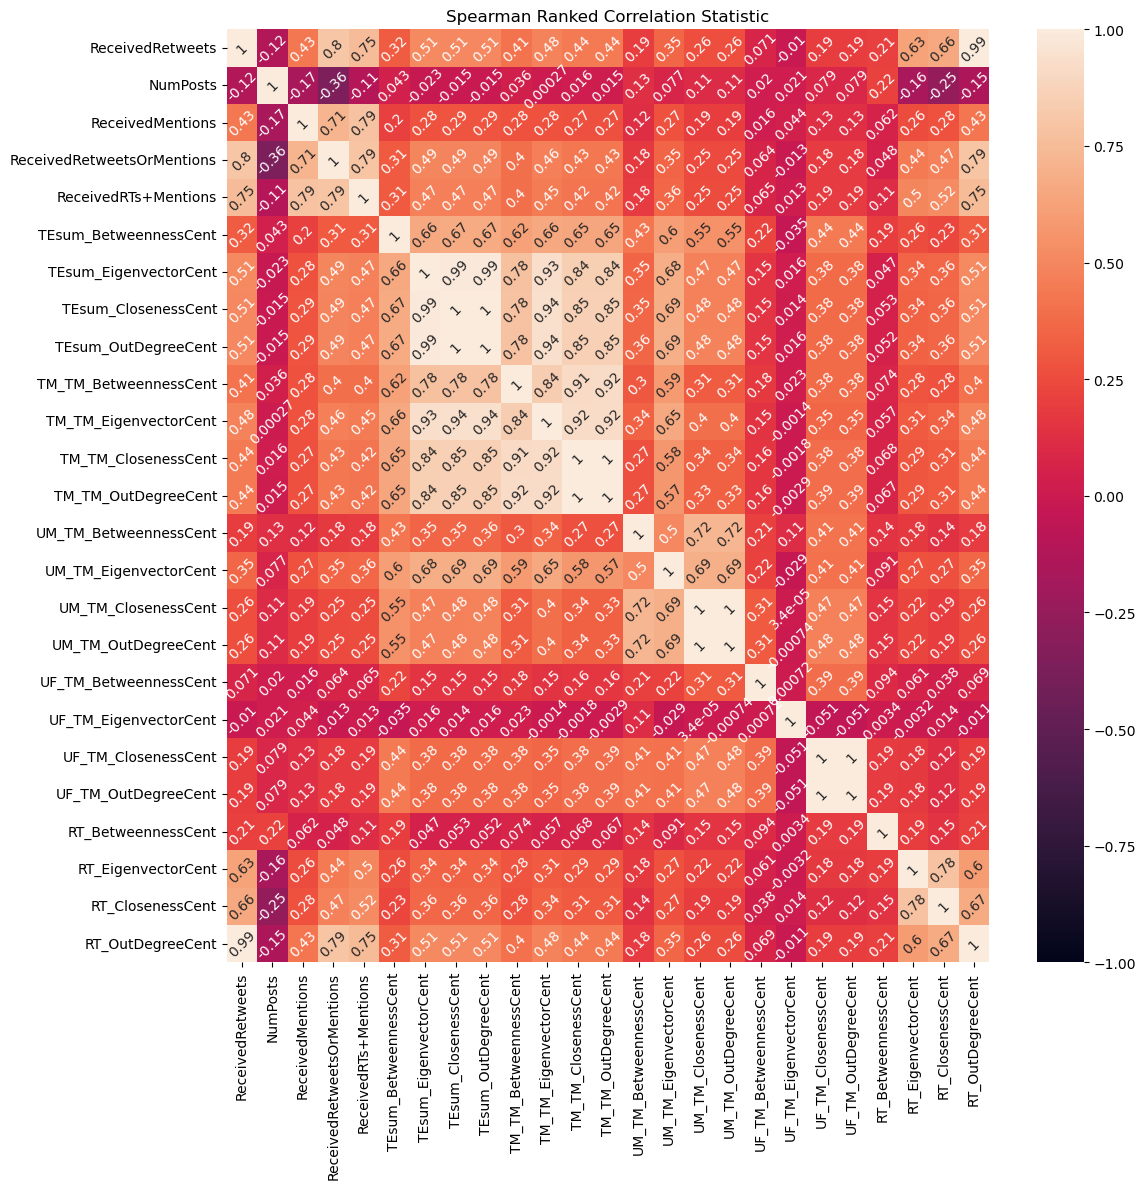

In [50]:
plt.figure(figsize=(12,12))
heatmap = sns.heatmap(srcpivot, vmin=-1, vmax=1, annot=True, annot_kws={'rotation': 45})#, cbar_kws = dict(location="bottom", anchor=(0.5,0.9), shrink=0.5))
#heatmap.tick_params(right=True, top=True, labelright=True, labeltop=True, rotation=0)
heatmap.set(ylabel=None, xlabel=None)
plt.xticks(rotation='vertical')
plt.title("Spearman Ranked Correlation Statistic")
plt.tight_layout()
plt.savefig("Spearman Ranked Correlation Statistic.png")

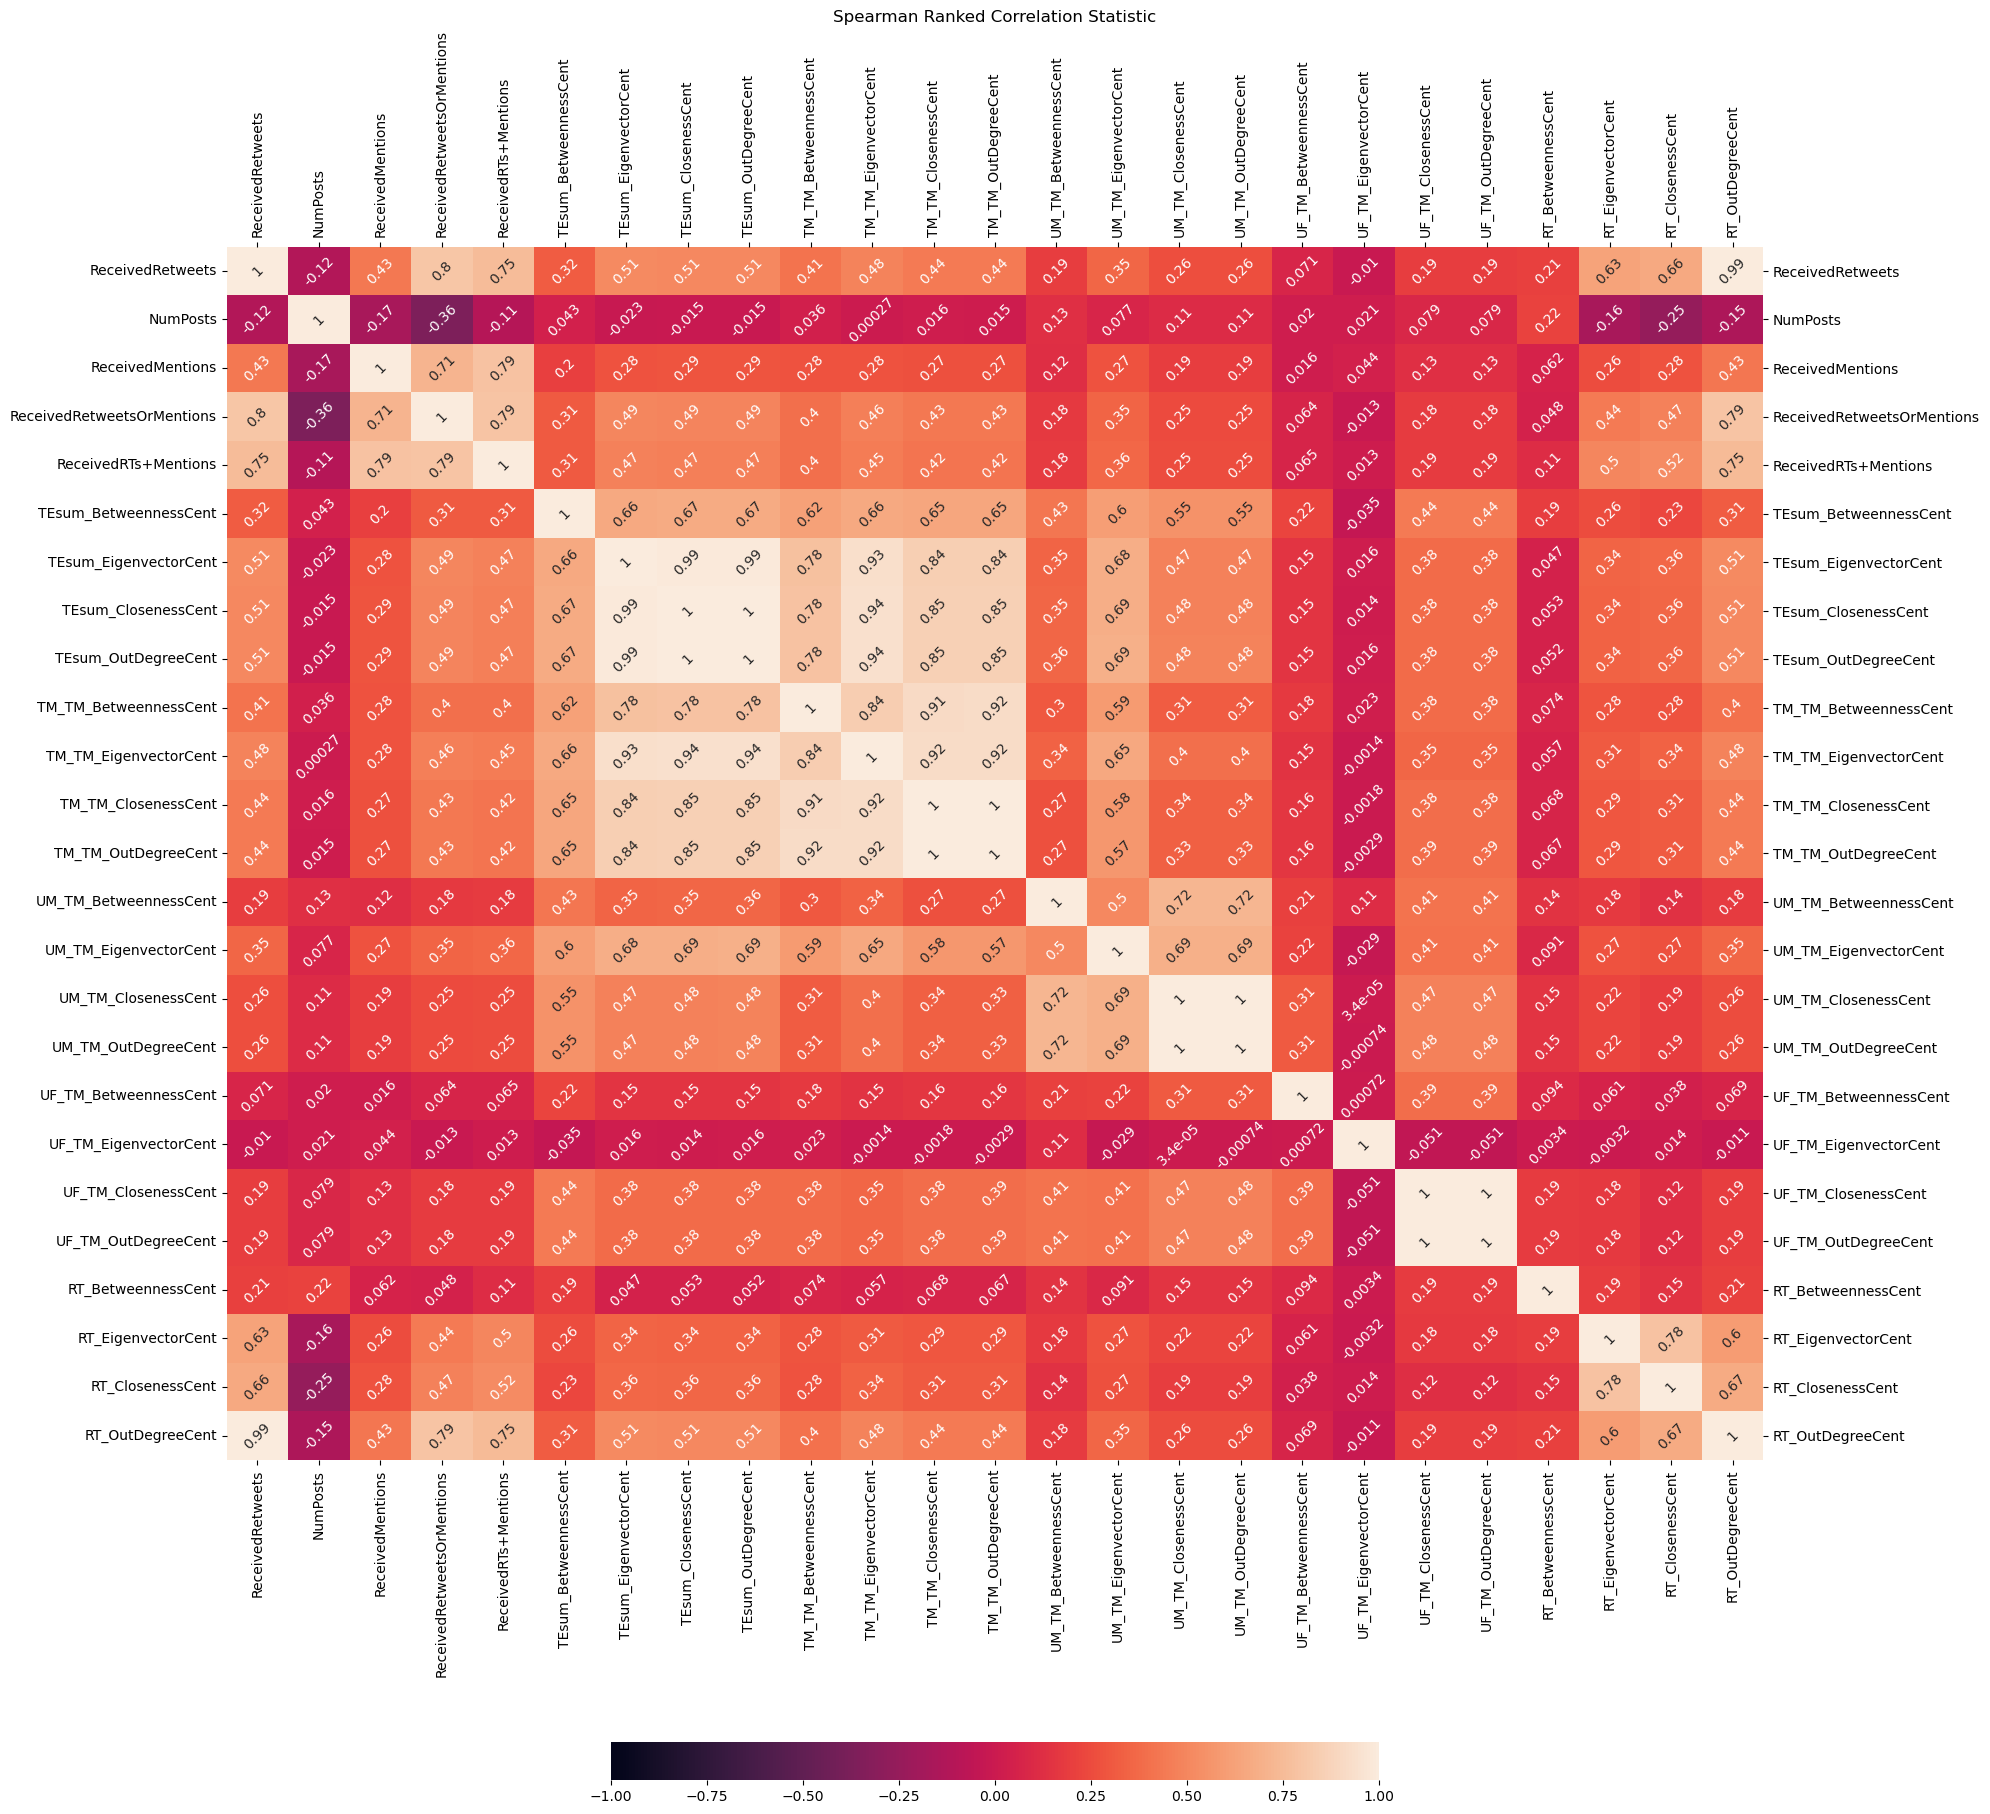

In [52]:
plt.figure(figsize=(20,20))
heatmap = sns.heatmap(srcpivot, vmin=-1, vmax=1, annot=True, annot_kws={'rotation': 45}, cbar_kws = dict(location="bottom", anchor=(0.5,0.9), shrink=0.5))
heatmap.tick_params(right=True, top=True, labelright=True, labeltop=True, rotation=0)
heatmap.set(ylabel=None, xlabel=None)
plt.xticks(rotation='vertical')
plt.title("Spearman Ranked Correlation Statistic")
plt.tight_layout()
plt.savefig("Spearman Ranked Correlation Statistic weighted.png")

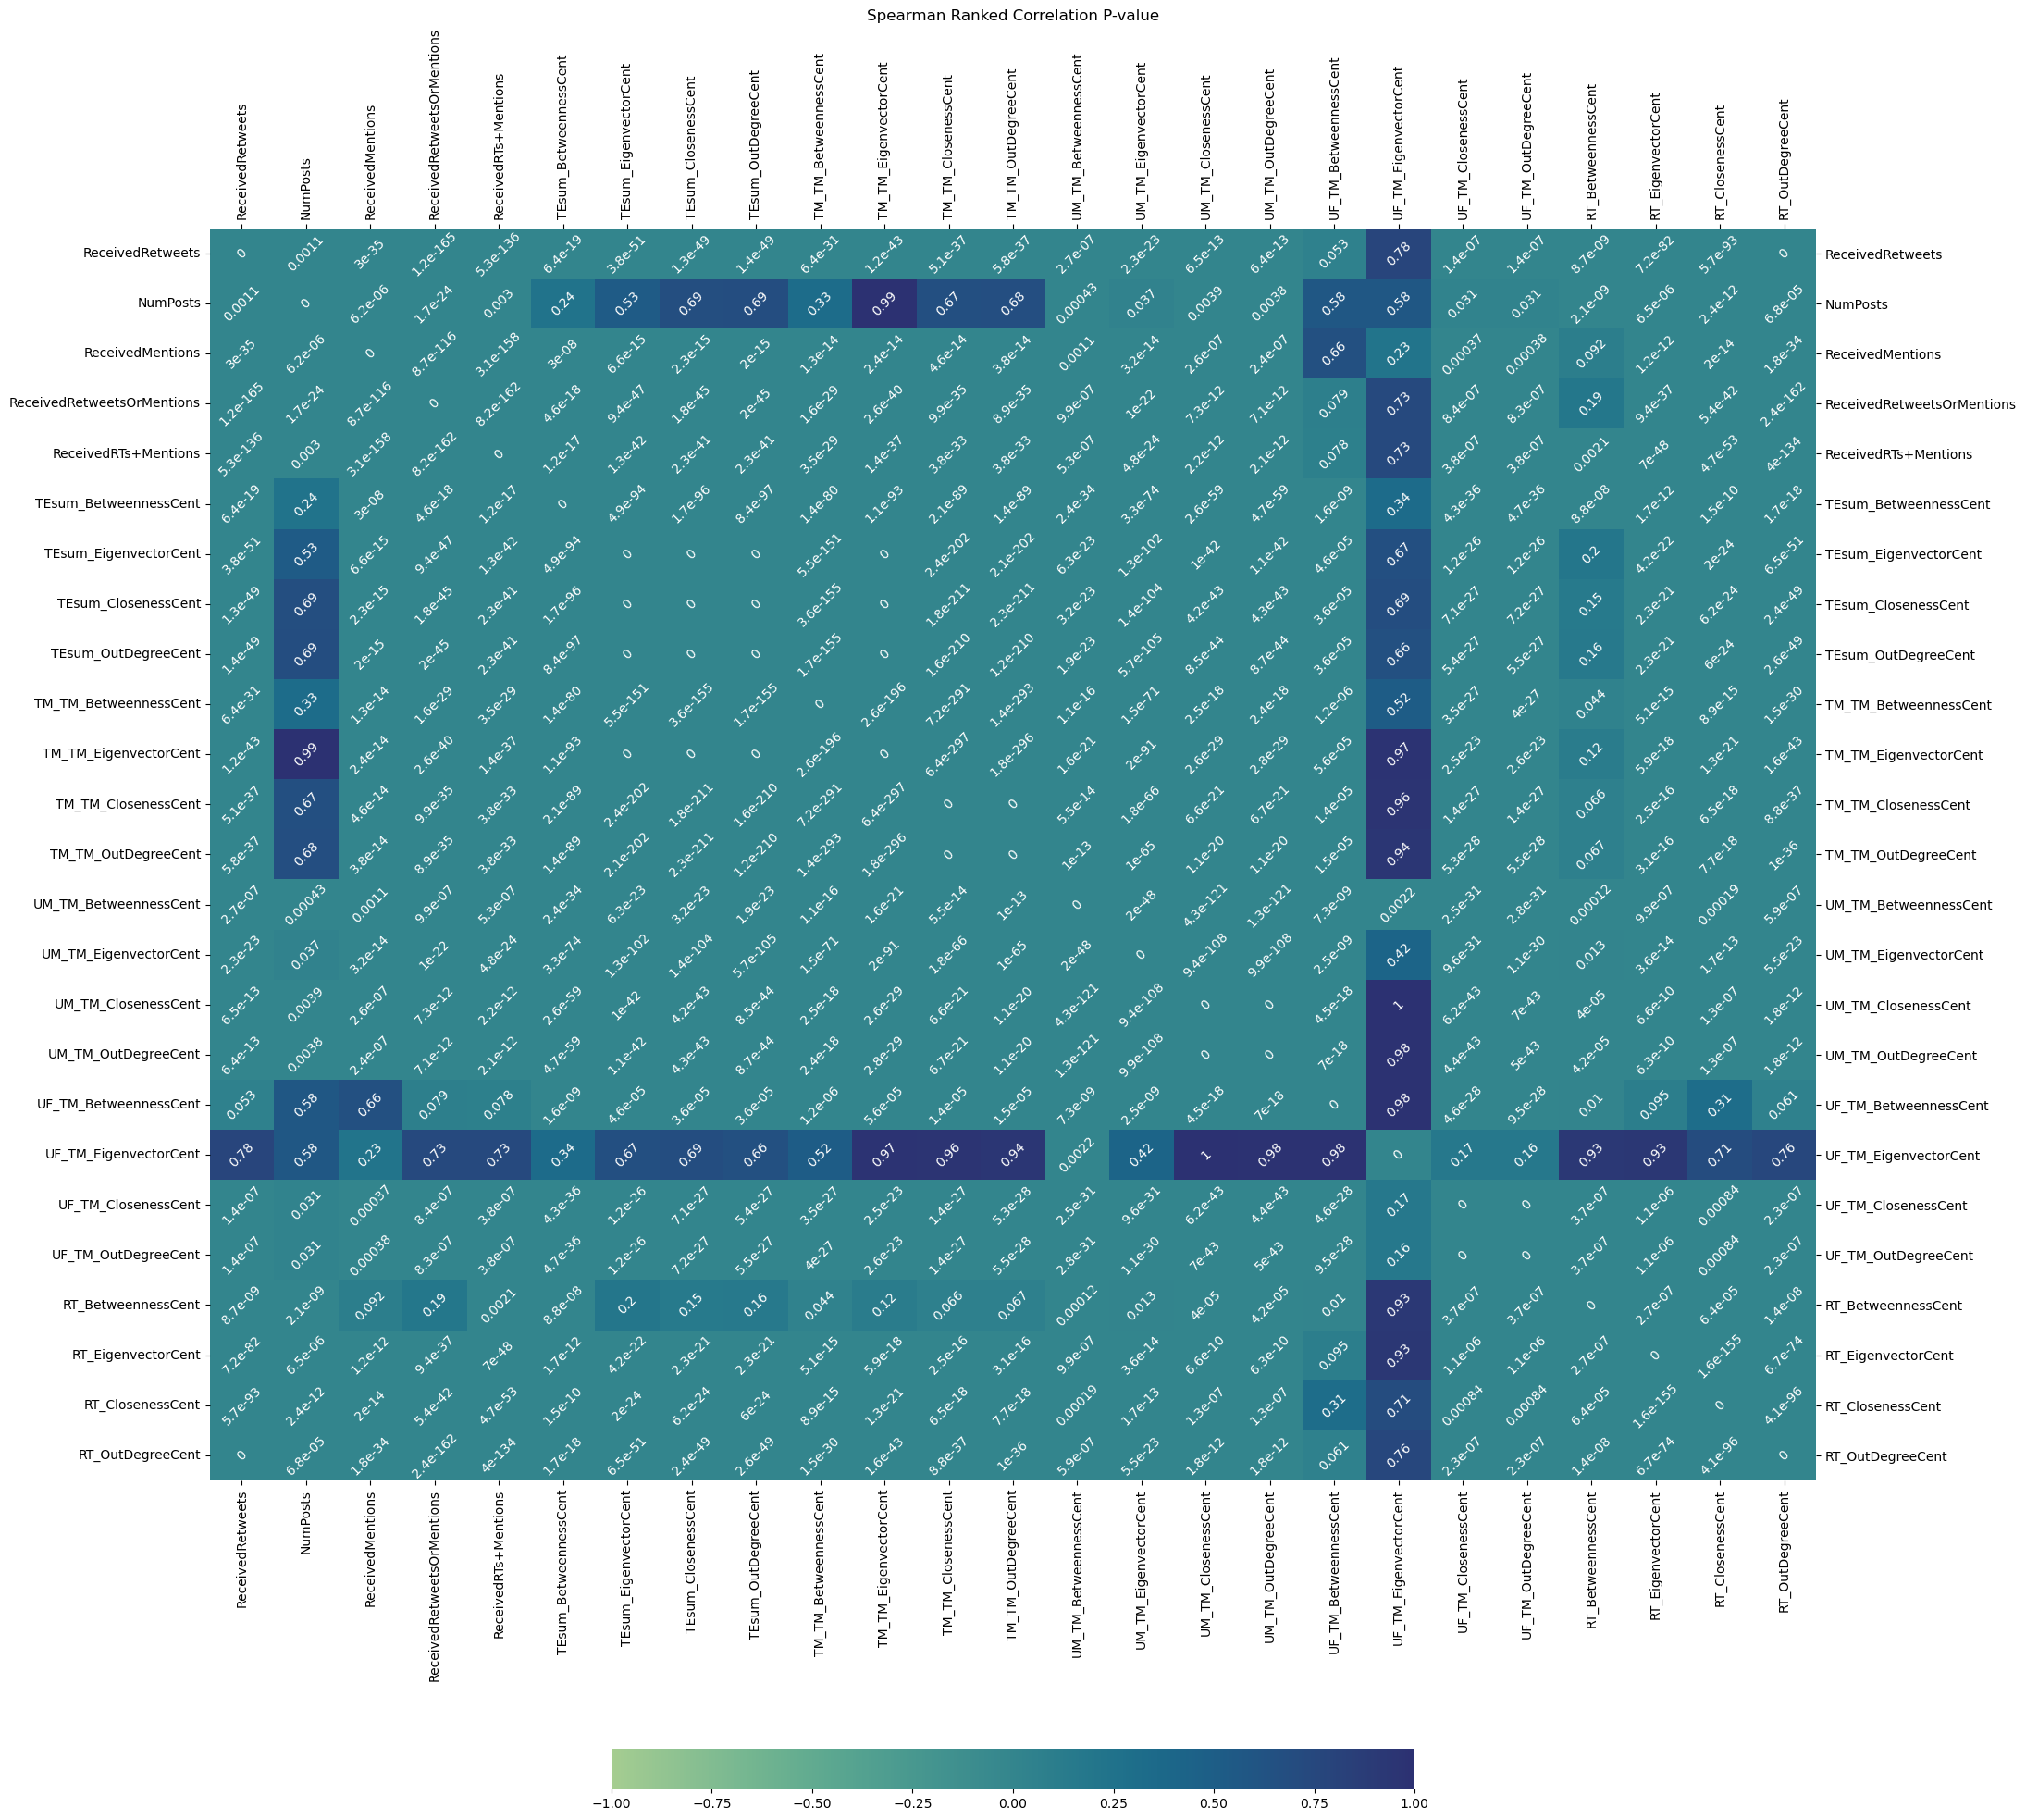

In [53]:
plt.figure(figsize=(22,22))
heatmap = sns.heatmap(srcpivot2, vmin=-1, vmax=1, annot=True, cmap="crest", annot_kws={'rotation': 45}, cbar_kws = dict(location="bottom", anchor=(0.5,1.0), shrink=0.5))
heatmap.tick_params(right=True, top=True, labelright=True, labeltop=True, rotation=0)
heatmap.set(ylabel=None, xlabel=None)
plt.xticks(rotation='vertical')
plt.title("Spearman Ranked Correlation P-value")
plt.tight_layout()
plt.savefig("Spearman Ranked Correlation P-value.png")

[1, 4, 3, 2, 5]
[1, 4, 3, 2, 5]


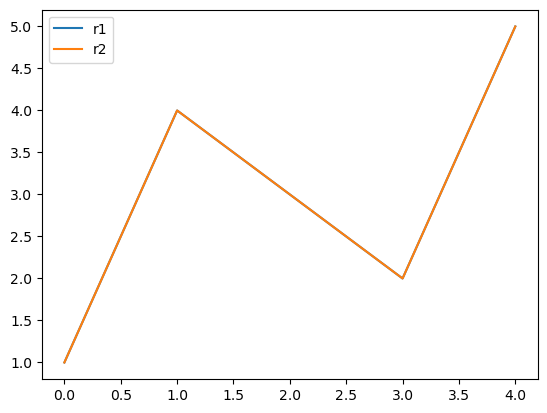

SignificanceResult(statistic=0.9999999999999999, pvalue=1.4042654220543672e-24)

In [45]:
r1 = [1,4,3,2,5] #df['TotalOutTE']
r2 = [1,4,3,2,5]
print(r1)
print(r2)
plt.plot(r1, label='r1')
plt.plot(r2, label='r2')
plt.legend()
plt.show()
r = stats.spearmanr(r1,r2)
r